#### 1.三边定位demo

ABC横坐标： [48.16404022 90.77106733 97.17821179] 
ABC纵坐标： [10.78655167 57.65315307 74.24741973]
待测点： 20.39067074522708 	 42.82487421006459


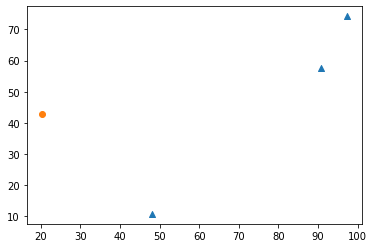

In [41]:
import sympy
import numpy as np
from matplotlib.pyplot import plot
from matplotlib.pyplot import show
import matplotlib.pyplot as plt
import matplotlib
 
# 生成三组ap坐标
MAX_X = 100
MAX_Y = 100
ap_x =MAX_X*np.random.rand(3)
ap_y = MAX_Y*np.random.rand(3)
print("ABC横坐标：",ap_x,"\nABC纵坐标：",ap_y)
plt.scatter(ap_x,ap_y,marker='^')
 
#生成待测点坐标
real_x = MAX_X*np.random.rand()
real_y = MAX_Y*np.random.rand()
print("待测点：",real_x,"\t",real_y)
plt.scatter(real_x,real_y,marker='o')

# 计算距离
d_A = ((real_x-ap_x[0])**2+(real_y-ap_y[0])**2)**0.5
d_B = ((real_x-ap_x[1])**2+(real_y-ap_y[1])**2)**0.5
d_C = ((real_x-ap_x[2])**2+(real_y-ap_y[2])**2)**0.5

In [56]:
def trilateration(x_A,y_A,d_A,x_B,y_B,d_B,x_C,y_C,d_C): 
    x,y = sympy.symbols('x y')
    f1 = 2*x*(x_A-x_C)+np.square(x_C)-np.square(x_A)+2*y*(y_A-y_C)+np.square(y_C)-np.square(y_A)-(np.square(d_C)-np.square(d_A))
    f2 = 2*x*(x_B-x_C)+np.square(x_C)-np.square(x_B)+2*y*(y_B-y_C)+np.square(y_C)-np.square(y_B)-(np.square(d_C)-np.square(d_B))
    result = sympy.solve([f1,f2],[x,y])
    loc_x,loc_y = result[x],result[y]
    return loc_x,loc_y
    
#解算得到定位节点坐标
loc_x,loc_y = trilateration(ap_x[0],ap_y[0],d_A,ap_x[1],ap_y[1],d_B,ap_x[2],ap_y[2],d_C)

In [52]:
(loc_x,loc_y)

(20.3906707452276, 42.8248742100643)

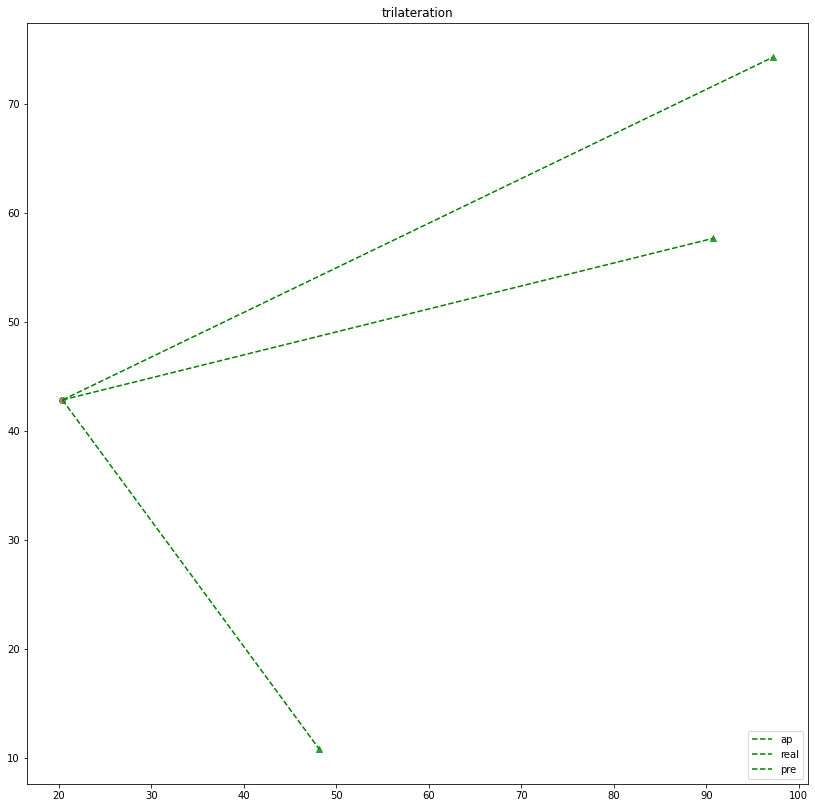

5.84764152721388e-13


In [71]:
#显示脚注
x = [[loc_x,ap_x[0]],[loc_x,ap_x[1]],[loc_x,ap_x[2]]]
y = [[loc_y,ap_y[0]],[loc_y,ap_y[1]],[loc_y,ap_y[2]]]

plt.figure(figsize=(14,14))

plt.scatter(real_x,real_y,marker='o')
plt.scatter(loc_x,loc_y,marker='*')
plt.scatter(ap_x,ap_y,marker='^')

for i in range(len(x)):
    plt.plot(x[i],y[i],linestyle = '--',color ='g' )
plt.title('trilateration')  
plt.legend(['ap','real','pre'], loc='lower right')
plt.show() 
derror = (np.square(loc_x-real_x) + np.square(loc_y-real_y)) **0.5
print(derror)  

#### 2.KNN回归方法 预测值为坐标

数据集来自<a>https://github.com/jiangqideng/codeInBlogs/tree/master/  坐标单位为cm

In [1]:
# 读取mat数据集
import numpy as np
import scipy.io as scio
offline_data = scio.loadmat('offline_data_random.mat')
online_data = scio.loadmat('online_data.mat')
location_ori, finger_ori = offline_data['offline_location'], offline_data['offline_rss']
location_val, finger_val = online_data['trace'][0:100, :], online_data['rss'][0:100, :]
del offline_data
del online_data

In [2]:
class knn_location:
    def __init__(self,finger_ori,location_ori,finger_val,location_val):
        self.finger_ori=finger_ori
        self.location_ori=location_ori
        self.finger_val=finger_val
        self.location_val=location_val

    def compute(self):
        d_all=[]
        for j in range(0,len(finger_val)):
            for i in range(0,len(self.finger_ori)):
                # (np.sum((np.array([5,4])-np.array([1,1]))**2))**0.5 计算欧氏距离
                d=(np.sum((finger_val[j]-finger_ori[i])**2))**0.5
                d_all.append(d)
        return d_all

In [3]:
# 平均定位误差
def accuracy(pre, location_val):
    return np.mean(np.sqrt(np.sum((pre - location_val)**2, 1)))

# 冒泡k次找出k个最接近的坐标
def bubble(d_all,label,k): 
  length = len(d_all) 
  for i in range(k): 
    for j in range(i+1,length): 
      if d_all[i] > d_all[j]: 
        d_all[j],d_all[i] = d_all[i],d_all[j]
        label[j],label[i]= label[i],label[j]
  return d_all[0:k],label[0:k]

In [4]:
knn_regressor=knn_location(finger_ori,location_ori,finger_val,location_val)
d_all=knn_regressor.compute()

In [5]:
# 把所有的欧式距离转换为np数组
d_all=np.array(d_all)
# 重组为每一行表示一个待测点与指纹集的所有距离
d_all=d_all.reshape(-1,len(finger_ori))

In [6]:
k=40
d_sort_all=[]
label_sort_all=[]

for val in range(0,len(finger_val)):
    label=np.array(range(0,len(finger_ori)))
    d_sort,label_sort=bubble(d_all[val],label,k)
    d_sort_all.append(d_sort)
    label_sort_all.append(label_sort)

In [7]:
pre=[]
for d in range(0,len(d_sort_all)):
    k_location=location_ori[label_sort_all[d]]
    pre.append(np.sum(k_location.T,axis=1)/k)

In [8]:
pre=np.array(pre)
# 计算平均定位误差
errors=accuracy(pre,location_val)
print("平均定位误差",errors/100,"m")

平均定位误差 2.300836741056577 m
